# Precision of numerical calculations

Here we demonstrate the precision of projected profiles calculated numerically vs. those calculated analytically. We will do this comparing the projection of a GNFW profile (which is always calculated numerically) and that of an NFW profile (which is always calculated analytically).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

Just to make plots a little nicer

In [19]:
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False

In [2]:
import profiley
profiley.__version__

'1.3.0b3'

In [3]:
from profiley.nfw import GNFW, NFW

Let's define the physical parameters for both profiles as an example:

In [4]:
mass = 1e14
concentration = 5
z = 0.1

the NFW profile:

In [5]:
nfw = NFW(mass, concentration, z)

and a GNFW profile with the same radial dependence, which we can obtain with the default parameters:

In [6]:
gnfw = GNFW(mass, concentration, z)

Let's first make sure we're looking at the same density profile:

In [7]:
R = np.logspace(-2, 1, 100)
rho_nfw = nfw.profile(R)
rho_gnfw = gnfw.profile(R)

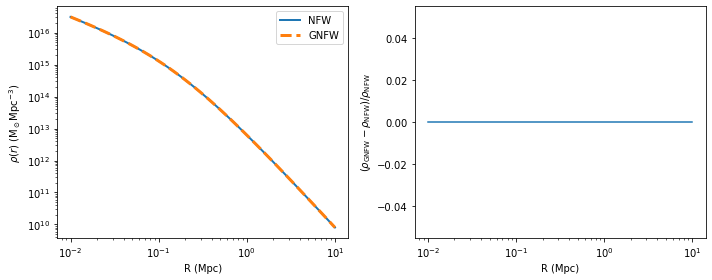

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(R, rho_nfw, lw=2, label='NFW')
axes[0].plot(R, rho_gnfw, '--', lw=3, label='GNFW')
axes[0].legend()
axes[0].set(ylabel=r'$\rho(r)$ (M$_\odot$Mpc$^{-3}$)', yscale='log')
axes[1].plot(R, (rho_gnfw-rho_nfw)/rho_nfw)
axes[1].set(ylabel=r'$(\rho_\mathrm{GNFW}-\rho_\mathrm{NFW})/\rho_\mathrm{NFW}$')
for ax in axes:
    ax.set(xlabel='R (Mpc)', xscale='log')
fig.tight_layout()

As expected, these two are *exactly* the same, because they are both calculated analytically. In contrast, the projected profile (i.e., surface density) of the GNFW is calculated numerically. Let's compare these:

In [15]:
%%time
proj_nfw = nfw.projected(R)

CPU times: user 477 µs, sys: 0 ns, total: 477 µs
Wall time: 487 µs


In [16]:
%%time
proj_gnfw = gnfw.projected(R)

CPU times: user 2.96 ms, sys: 35 µs, total: 2.99 ms
Wall time: 2.09 ms


We can already see how much longer the numerical calculation takes. In terms of precision:

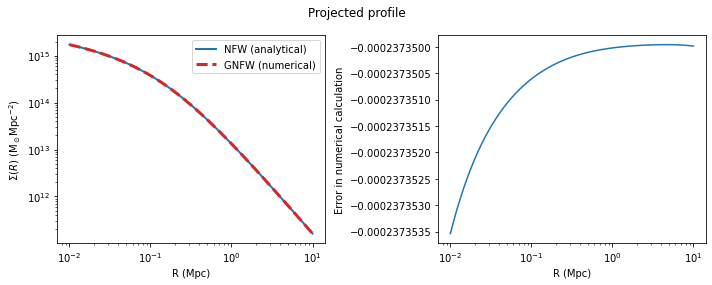

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Projected profile')
axes[0].plot(R, proj_nfw, lw=2, label='NFW (analytical)')
axes[0].plot(R, proj_gnfw, 'C3--', lw=3, label='GNFW (numerical)')
axes[0].legend()
axes[0].set(ylabel=r'$\Sigma(R)$ (M$_\odot$Mpc$^{-2}$)', yscale='log')
axes[1].plot(R, ((proj_gnfw-proj_nfw)/proj_nfw))
axes[1].set(ylabel='Error in numerical calculation')
for ax in axes:
    ax.set(xlabel='R (Mpc)', xscale='log')
fig.tight_layout()

This precision is probably higher than required for most applications. There are a few parameters we can tune to adjust the precision/execution time trade-off. These are specified in the docs and you are encouraged to modify them if needed:

In [21]:
help(gnfw.projected)

Help on method projected in module profiley.core:

projected(R: numpy.ndarray, log_rmin=-10, log_rmax=6, integral_samples=200) method of profiley.nfw.GNFW instance
    Line of sight projected profile, calculated numerically
    
    Parameters
    ----------
    R : np.ndarray
        positions at which to calculate the projected profile
    
    Optional arguments
    ------------------
    log_rmin, log_rmax : float
        lower and upper limits for logspace resampling for integration
    integral_samples : int
        number of samples to generate for Simpson-rule integration
        of the projected profile
    
    
    Notes on numerical integration
    ------------------------------
     -The default values for the integration parameters give
        numerical errors well below 0.1% over the range
        R=[1e-5,100] Mpc, when comparing the numerical and
        analytical implementations for an NFW profile (the
        former can be obtained by defining a GNFW profile with
  

Similarly for the cumulative profile:

In [23]:
%%time
cum_nfw = nfw.projected_cumulative(R)

CPU times: user 346 µs, sys: 0 ns, total: 346 µs
Wall time: 952 µs


In [24]:
%%time
cum_gnfw = gnfw.projected_cumulative(R)

CPU times: user 14.1 ms, sys: 8.27 ms, total: 22.4 ms
Wall time: 26 ms


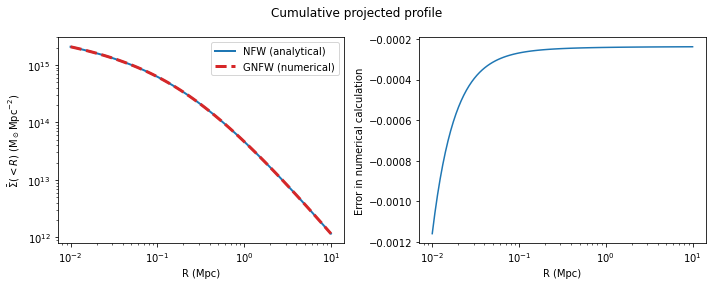

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Cumulative projected profile')
axes[0].plot(R, cum_nfw, lw=2, label='NFW (analytical)')
axes[0].plot(R, cum_gnfw, 'C3--', lw=3, label='GNFW (numerical)')
axes[0].legend()
axes[0].set(ylabel=r'$\bar\Sigma(<R)$ (M$_\odot$Mpc$^{-2}$)', yscale='log')
axes[1].plot(R, ((cum_gnfw-cum_nfw)/cum_nfw))
axes[1].set(ylabel='Error in numerical calculation')
for ax in axes:
    ax.set(xlabel='R (Mpc)', xscale='log')
fig.tight_layout()

For completeness, here are the docs for the cumulative projected profile:

In [33]:
help(gnfw.projected_cumulative)

Help on method projected_cumulative in module profiley.core:

projected_cumulative(R: numpy.ndarray, log_rmin: float = -10, left_samples: int = 100, resampling: int = 20, **kwargs) method of profiley.nfw.GNFW instance
    Cumulative projected profile within R, calculated
    numerically
    
    Parameters
    ----------
    R : np.ndarray
        positions at which to calculate the projected profile
    
    Optional arguments
    ------------------
    log_rmin : float
        lower limit for logspace resampling for integration. The
        same value will be passed to ``self.projected``
    resampling : int
        number of samples into which each R-interval in the
        data will be re-sampled. For instance, if two adjacent
        data points are at Rbin=0.1,0.2 then for the integration
        they will be replaced by
            newRbin = np.logspace(np.log10(0.1), np.log10(0.2),
                                  resampling, endpoint=False)
        (the endpoint will be added